In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import math
sys.path.append('../')
from Scattering_Simulator import pairwise_method
from Scattering_Simulator import Read_PDB
from scipy import integrate
import h5py
import plotly.express as px

c:\Users\htchi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Summary 
This notebook contains code used to create the RhuA tube like structures and to simulate the scattering curve of the structure. The coordinates of the RhuA protein is first loaded from its PDB file. It is then assembled into a helical structure. The scattering curve of the tube is then obtained using the MC-DFM. 

## Load the Coordinates of the Building Block

In [17]:
coordinates = Read_PDB.load_pdb('../Data/PDB/RhuA/1ojr.pdb1')

In [3]:
fig = px.scatter_3d(pd.DataFrame(coordinates, columns=['x','y','z','sld']), x ='y', y='x',z='z', color='sld', size='sld', opacity=.95, color_continuous_scale=px.colors.sequential.PuBu)

fig.update_traces(marker=dict(
                              line=dict(width=0,
                                        color='black')),
                  selector=dict(mode='markers'))

fig.update_layout(scene_camera=dict(
    eye=dict(x=1.2, y=1.2, z=0.6),
    center=dict(x=0, y=0, z=0),
    up=dict(x=3, y=3, z=0)))

fig.update_layout(coloraxis_colorbar=dict(
    title="SLD",
    thicknessmode="pixels", thickness=20,
    lenmode="pixels", len=300,
    yanchor="top", y=1,
    ticks="outside", ticksuffix="",
    dtick=8
))

fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.show()

#fig.write_image("../Images/RhuA/RhuA_Image_Test_1.png", scale=5) 

The following functions will be used to create the coordinates of the helix and place the protein on each of the coordinates. Some functions will also be used to rotate the protein.

In [18]:
def helix_coord(amp, f , low, high, n):
    y = np.linspace(low, high, n)
    x = amp*np.cos(f*y)
    z = amp*np.sin(f*y)
    return x, y, z

def Cube(low_x, high_x, n_x, low_y, high_y, n_y, low_z, high_z, n_z): 
    x = np.linspace(low_x, high_x, n_x)
    y = np.linspace(low_y, high_y, n_y)
    z = np.linspace(low_z, high_z, n_z)
    xx, yy, zz = np.meshgrid(x,y,z)
    xx = meshgrid_to_array(xx)
    yy = meshgrid_to_array(yy)
    zz = meshgrid_to_array(zz)
    coordinates = np.hstack((xx,yy,zz))
    return coordinates

def meshgrid_to_array(xx):
    x_lst = []
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            for k in range(xx.shape[2]):
                x_lst.append(xx[i,j,k])
    coordinates = np.array(x_lst).reshape(-1,1)
    return coordinates 

def relative_coordinates(volume):
    # Determine the points relative to (0,0)
    rel_x = volume[:,0] - np.mean(volume[:,0])
    rel_y = volume[:,1] - np.mean(volume[:,1])
    rel_z = volume[:,2] - np.mean(volume[:,2])
    relative_volume = np.hstack((rel_x.reshape(-1,1), rel_y.reshape(-1,1), rel_z.reshape(-1,1), volume[:,-1].reshape(-1,1)))
    return relative_volume

def rotation_angle(x,z,r):
    angle = -np.arctan2(z, x)*180/math.pi
    return np.round(angle)

def rotate_coordinates_y(x, z, angle):
    angle = angle*math.pi/180
    x_new = x*np.cos(angle) + z*np.sin(angle)
    z_new = -x*np.sin(angle) + z*np.cos(angle)
    return x_new, z_new

def rotate_coordinates_x(y, z, angle):
    angle = angle*math.pi/180
    y_new = y*np.cos(angle) + z*np.sin(angle)
    z_new = -y*np.sin(angle) + z*np.cos(angle)
    return y_new, z_new

def rotate_coordinates_z(x, y, angle):
    angle = angle*math.pi/180
    x_new = x*np.cos(angle) + y*np.sin(angle)
    y_new = -x*np.sin(angle) + y*np.cos(angle)
    return x_new, y_new

def rotate_coordinates(x, z, angle):
    angle = angle*math.pi/180
    x_new = x*np.cos(angle) + z*np.sin(angle)
    z_new = -x*np.sin(angle) + z*np.cos(angle)
    return x_new, z_new

def place_structure(relative_volume, x,y,z):
    x_coord = relative_volume[:,0] + x
    y_coord = relative_volume[:,1] + y
    z_coord = relative_volume[:,2] + z
    structure_coordinates = np.hstack((x_coord.reshape(-1,1), y_coord.reshape(-1,1), z_coord.reshape(-1,1), relative_volume[:,-1].reshape(-1,1)))
    return structure_coordinates

def amp_Calculate(inner, outer):
    return (inner+outer)*10/2/2

## Rotate the coordinates of the protein in the upper and lower configurations

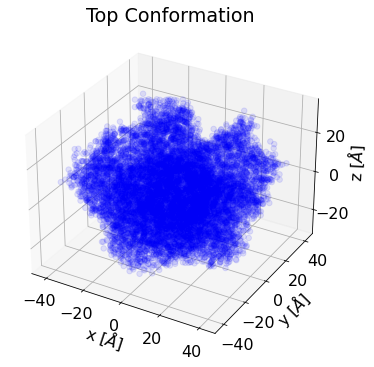

In [27]:
coordinates = Read_PDB.load_pdb('../Data/PDB/RhuA/1ojr.pdb1')
coordinates = relative_coordinates(coordinates)
coordinates[:,1], coordinates[:,2] = rotate_coordinates_x(coordinates[:,1], coordinates[:,2], 90)
volume = coordinates
volume_rotated = np.hstack((volume[:,0].reshape(-1,1), volume[:,2].reshape(-1,1), volume[:,1].reshape(-1,1), volume[:,-1].reshape(-1,1)))
# Plot the mean of all points
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.scatter(volume_rotated[:,0],volume_rotated[:,1],volume_rotated[:,2], color = 'blue', alpha = 0.1, s = 30)
ax.set_xlabel('x [$\AA$]')
ax.set_ylabel('y [$\AA$]')
ax.set_zlabel('z [$\AA$]')
ax.set_title('Top Conformation')
plt.show()
#ax.set_xlabel('Diameter of Tube')
#ax.set_ylabel('Length of Tube')
#ax.set_zlabel('Diameter of Tube')
#ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#plt.savefig('Figures/RhuA_up.jpg')

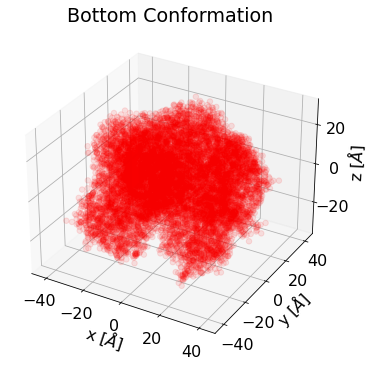

In [28]:
# Plot the mean of all points
volume_xr, volume_zr = rotate_coordinates_y(volume_rotated[:,0], volume_rotated[:,2], 180)
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.scatter(volume_xr, volume[:,2], volume_zr, color = 'red', alpha = 0.1, s = 30)
ax.set_xlabel('x [$\AA$]')
ax.set_ylabel('y [$\AA$]')
ax.set_zlabel('z [$\AA$]')
ax.set_title('Bottom Conformation')
plt.show()
# ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#plt.savefig('Figures/RhuA_down.jpg')

## Assemble the proteins in a tube like structure.
The following code will be used to find the coodinates of the helix where the proteins will be assembled on. The coordinates of one full rotation of the helix will be created. 

In [29]:
OD = 104 #Outer diameter of the helix in units of nm
amp = amp_Calculate(OD, OD-10)
amp

495.0

Text(0.5, 0, 'z [$\\AA$]')

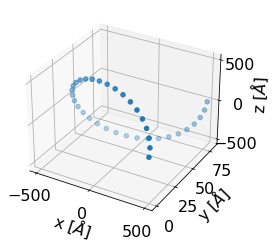

In [30]:
# Create a helix and find coordinates on it 
amp = amp 
start = 35

full_circles = 1 # Number of full circles (15)
low = 0
high = full_circles*80 # Length of Tube, Assuming that one circle is 80 A thick, high = full_circles*80
n = int(start*full_circles+1) # Number of Points 
f = full_circles*2*math.pi/high #frequency


x, y, z = helix_coord(amp, f, low, high, n)
plt.rcParams.update({'font.size': 16})
ax = plt.axes(projection='3d')
ax.scatter(x,y,z)
ax.set_xlabel('x [$\AA$]')
ax.set_ylabel('y [$\AA$]')
ax.set_zlabel('z [$\AA$]')
#plt.savefig('../Figures/RhuA/Helix_Coordinates.png', dpi=300, bbox_inches="tight")

The coordinates of each protein will then be placed on each of the coordinates of the helix alternating between the top and bottom conformation. 

In [31]:
# Find the relative volume of the coordinates which is the coordinates centered at 0,0,0
relative_volume = relative_coordinates(volume_rotated)
# Add the relaive coordinates to coordinates on the helix 
angle_lst = []
color_lst = []
for i in range(len(x)):
    if i%2 == 0: #Alternate RhuA structure
        angle = rotation_angle(x[i], z[i], amp) + (90+180)
        color = 1
    else:
        angle = rotation_angle(x[i], z[i], amp) + 90
        color = 2
    x_list = []
    z_list = []
    angle_lst.append(angle)
    for j in range(relative_volume.shape[0]): 
        x_new, z_new = rotate_coordinates(relative_volume[j,0], relative_volume[j,2], angle)
        x_list.append(x_new)
        z_list.append(z_new)
        color_lst.append(color)
    struc_coordinates = np.hstack((np.array(x_list).reshape(-1,1), relative_volume[:,1].reshape(-1,1), np.array(z_list).reshape(-1,1), relative_volume[:,-1].reshape(-1,1)))
    struc_coordinates = place_structure(struc_coordinates, x[i], y[i], z[i])
    if i == 0:
        coordinates = struc_coordinates
    else:
        coordinates = np.vstack((coordinates, struc_coordinates,))

In [32]:
protein_1 = coordinates[np.where(np.array(color_lst) == 1)[0], :]
protein_2 = coordinates[np.where(np.array(color_lst) == 2)[0], :]

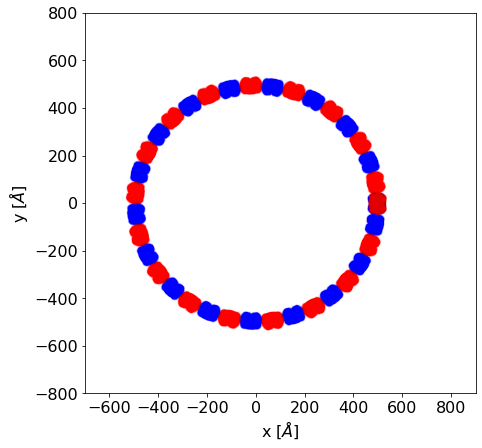

In [35]:
plt.rcParams.update({'font.size': 16})
fig = plt.subplots(figsize=(7,7))
plt.scatter(protein_1[:,0],protein_1[:,2], color = 'Blue', s = 9, alpha = 0.03)
plt.scatter(protein_2[:,0],protein_2[:,2], color = 'Red', s = 9, alpha = 0.03)
#plt.scatter([200, 400, 600, 800, 1000], [0, 0, 0, 0, 0], s = 100, color = 'k')
#plt.xlabel('Diameter of Tube, y-axis [$\AA$]')
#plt.ylabel('Diameter of Tube, z-axis [$\AA$]')
plt.xlabel('x [$\AA$]')
plt.ylabel('y [$\AA$]')
plt.xlim([-700,900])
plt.ylim([-800,800])
#plt.savefig('../Figures/RhuA/tube_side.png', dpi=300, bbox_inches="tight")
plt.show()

## Sample from the Building Block
The coordinates of the RhuA protein in one full rotation of the helical structure shown above is the "building block".

In [37]:
n_samples = 10000000

In [38]:
simulator = pairwise_method.scattering_simulator(n_samples)
simulator.sample_building_block(coordinates)

## Sample from the Lattice
The lattice is composed of 30 points that are spaced 80 nm from each other.

In [39]:
lattice_points_x = 1 #9
lattice_points_y = 30 #14
lattice_points_z = 1 #9
lattice_spacing_x = 0 #530
lattice_spacing_y = 80 #80
lattice_spacing_z = 0 #530
simulator.sample_lattice_function(lattice_spacing_x, lattice_spacing_y, lattice_spacing_z, lattice_points_x, lattice_points_y, lattice_points_z)
#simulator.use_building_block_as_structure()

## Sample from the Structure (Building Block + Lattice)
By sampling the building block and lattice independently, we can obtain the pairwise distribution from the whole structure. 

In [40]:
simulator.calculate_structure_coordinates()

## Simulate the Scattering Curve
The scattering curve can be calculated from the pairwise distribution. This command simulates the scattering curve 10 times and takes the average of all the curves. 

In [41]:
histogram_bins = 10000
q = np.geomspace(0.004, 0.2, 6000)
I_q = simulator.simulate_multiple_scattering_curves_lattice(coordinates, histogram_bins, q, lattice_spacing_x, lattice_spacing_y, lattice_spacing_z, lattice_points_x, lattice_points_y, lattice_points_z)

## Plot the Scattering Curve

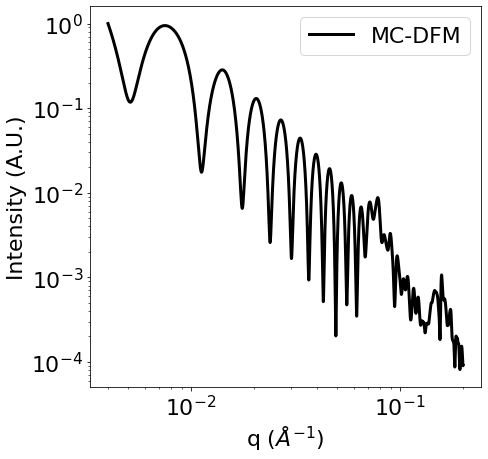

In [61]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(7,7))
background = 0
plt.plot(q, np.mean(I_q, axis=1) + background, linewidth = 3, label = 'MC-DFM', color='k')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Intensity (A.U.)')
plt.xlabel('q ($\AA^{-1}$)')
ax.minorticks_on()
plt.legend(loc=1)
plt.show()
#plt.savefig('../Images/Comparison.png', dpi=300, bbox_inches="tight")
data = np.hstack((q.reshape(-1,1), np.mean(I_q, axis=1).reshape(-1,1)))
#np.save('../Data/simulated_scattering/RhuA_3/RhuA_' + str(amp) + '_amp_' + str(start) + '_start_' + str(OD) + 'nm_OD.npy', data)

To confirm which object the scattering curve belongs to, we can plot the randomly sampled coordiantes used to create the pairwise distribution. As expected, the object is the tube like structure made from assembling the RhuA protein. 

Text(0, 0.5, 'z axis [$\\AA$]')

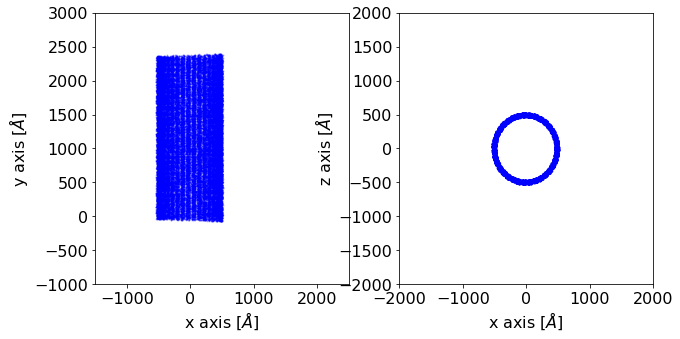

In [59]:
struc = simulator.structure_coordinates_1
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10,5), ncols=2, nrows=1)
ax[0].scatter(struc[:,0][::300], struc[:,1][::300], alpha = 0.25, s=1, color = 'blue')
ax[0].set_xlim([-1500,2500])
ax[0].set_ylim([-1000,3000])
ax[0].set_xlabel('x axis [$\AA$]')
ax[0].set_ylabel('y axis [$\AA$]')
ax[1].scatter(struc[:,0][::300], struc[:,2][::300], alpha = 0.25, s=1, color = 'blue')
ax[1].set_xlim([-2000,2000])
ax[1].set_ylim([-2000,2000])
ax[1].set_xlabel('x axis [$\AA$]')
ax[1].set_ylabel('z axis [$\AA$]')

#plt.savefig('../Images/Sampled_Electron_Density_Tube_assembly_2.png', dpi=300, bbox_inches="tight")